In [20]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, confusion_matrix, roc_auc_score,
                             classification_report)
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------ Model Imports ------------------
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [21]:
# =============================================================================
# PARAMETERS: Adjust these as needed
# =============================================================================

task = "classification"  # Options: "regression" or "classification"
do_tuning = False         # Set True to tune hyperparameters, False to just fit with initial parameters

# List the model names to test.
if task == "regression":
    selected_models = [
        # "XGBRegressor", 
        "LGBMRegressor", 
        # "LinearRegression", 
        # "KNNRegressor", 
        # "SVR", 
        # "RandomForestRegressor"
    ]
else:
    selected_models = [
        # "XGBClassifier", 
        "LGBMClassifier", 
        # "LogisticRegression", 
        # "KNNClassifier", 
        # "SVC", 
        # "RandomForestClassifier"
    ]

In [72]:
# =============================================================================
# FUNCTIONS
# =============================================================================

def load_and_split_data(path: str, task: str):
    """
    Load the dataset, clean it, and perform a temporal train-test split.
    """
    df = pd.read_parquet(path)
    df = df.drop(columns=["magnitudes_list"])
    
    # Drop rows with missing target values
    if task == "regression":
        df = df.dropna(subset=["max_mag_next_30d"])
    else:
        df = df.dropna(subset=["target_class"])
    
    df["date"] = pd.to_datetime(df["date"])
    
    # Select target column based on task
    target_col = "max_mag_next_30d" if task == "regression" else "target_class"
    X = df.drop(columns=["max_mag_next_30d", "target_class"])
    y = df[target_col]
    
    # For classification, shift labels to start at 0
    if task == "classification":
        y = y - 1
    
    # Temporal train-test split:
    #   Train: dates before 2024-01-01
    #   Test: dates from 2024-01-30 onward
    X_train = X.loc[X.date < "2024-01-01"].copy()
    X_test  = X.loc[X.date >= "2024-01-30"].copy()
    y_train = y.loc[X.date < "2024-01-01"].copy()
    y_test  = y.loc[X.date >= "2024-01-30"].copy()
    
    # Drop the date column since it's no longer needed
    X_train = X_train.drop(columns=["date"])
    X_test  = X_test.drop(columns=["date"])
    
    return X_train, X_test, y_train, y_test

def build_preprocessor():
    """
    Build a preprocessing pipeline with median imputation and standard scaling.
    """
    return Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

def get_model_and_param_grid(model_name: str, task: str, y_train=None):
    """
    Given a model name and task, return the model instance and its hyperparameter grid.
    """
    if task == "regression":
        if model_name == "XGBRegressor":
            model = XGBRegressor(n_estimators=1000,
                                 learning_rate=0.01,
                                 max_depth=3,
                                 min_child_weight=10,
                                 gamma=0.5,
                                 subsample=0.7,
                                 colsample_bytree=0.7,
                                 reg_lambda=10,
                                 reg_alpha=1,
                                 random_state=42)
            param_grid = {
                'model__max_depth': [3, 5],
                'model__learning_rate': [0.01, 0.05],
                'model__min_child_weight': [10, 20]
            }
        elif model_name == "LGBMRegressor":
            model = LGBMRegressor(random_state=42, verbose=-1)
            param_grid = {
                'model__num_leaves': [31, 50],
                'model__learning_rate': [0.01, 0.05]
            }
        elif model_name == "LinearRegression":
            model = LinearRegression()
            param_grid = {}
        elif model_name == "KNNRegressor":
            model = KNeighborsRegressor()
            param_grid = {
                'model__n_neighbors': [3, 5, 7]
            }
        elif model_name == "SVR":
            model = SVR()
            param_grid = {
                'model__C': [0.1, 1, 10],
                'model__kernel': ['linear', 'rbf']
            }
        elif model_name == "RandomForestRegressor":
            model = RandomForestRegressor(random_state=42)
            param_grid = {
                'model__n_estimators': [100, 200],
                'model__max_depth': [None, 5, 10]
            }
        else:
            raise ValueError(f"Invalid regression model name: {model_name}")
    else:
        if model_name == "XGBClassifier":
            num_class = len(np.unique(y_train)) if y_train is not None else 3
            model = XGBClassifier(n_estimators=500,
                                  learning_rate=0.05,
                                  max_depth=3,
                                  min_child_weight=10,
                                  gamma=0.5,
                                  subsample=0.7,
                                  colsample_bytree=0.7,
                                  reg_lambda=10,
                                  reg_alpha=1,
                                  objective="multi:softmax",
                                  num_class=num_class,
                                  random_state=42)
            param_grid = {
                'model__max_depth': [3, 5],
                'model__learning_rate': [0.05, 0.1],
                'model__min_child_weight': [10, 20]
            }
        elif model_name == "LGBMClassifier":
            model = LGBMClassifier(
                random_state=42,
                verbose=-1,
                num_leaves=8,           # Fewer leaves than default (reduces model complexity)
                max_depth=3,             # Constrains tree depth
                min_child_samples=50,    # Requires more samples in each leaf
                feature_fraction=0.8,    # Uses only 80% of features per tree
                bagging_fraction=0.8,    # Uses only 80% of data per iteration
                bagging_freq=1,          # Enables bagging at every iteration
                learning_rate=0.1,       # A moderate learning rate
                lambda_l1=0.5,           # L1 regularization
                lambda_l2=0.5            # L2 regularization
            )

            param_grid = {
                'model__num_leaves': [31, 50],
                'model__learning_rate': [0.05, 0.1]
            }
        elif model_name == "LogisticRegression":
            model = LogisticRegression(max_iter=1000, random_state=42)
            param_grid = {
                'model__C': [0.1, 1, 10]
            }
        elif model_name == "KNNClassifier":
            model = KNeighborsClassifier()
            param_grid = {
                'model__n_neighbors': [3, 5, 7]
            }
        elif model_name == "SVC":
            model = SVC(probability=True, random_state=42)
            param_grid = {
                'model__C': [0.1, 1, 10],
                'model__kernel': ['linear', 'rbf']
            }
        elif model_name == "RandomForestClassifier":
            model = RandomForestClassifier(random_state=42)
            param_grid = {
                'model__n_estimators': [100, 200],
                'model__max_depth': [None, 5, 10]
            }
        else:
            raise ValueError(f"Invalid classification model name: {model_name}")
    return model, param_grid

def evaluate_model(model_pipeline: Pipeline, X, y, dataset: str, task: str):
    """
    Evaluate the given model pipeline on dataset (training or test), print performance metrics,
    and plot a heatmap of the confusion matrix for classification tasks.
    """
    y_pred = model_pipeline.predict(X)
    print(f"\n{dataset} Set Evaluation:")
    if task == "regression":
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        r2  = r2_score(y, y_pred)
        print(f"MSE: {mse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R2: {r2:.4f}")
    else:
        acc = accuracy_score(y, y_pred)
        cm  = confusion_matrix(y, y_pred)
        print(f"Accuracy: {acc:.4f}")
        print("Confusion Matrix (raw):")
        print(cm)
        
        # Plot confusion matrix as a heatmap
        classes = np.unique(np.concatenate((y, y_pred)))
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'{dataset} Confusion Matrix')
        plt.show()
        
        if hasattr(model_pipeline.named_steps['model'], "predict_proba"):
            y_proba = model_pipeline.predict_proba(X)
            try:
                roc_auc = roc_auc_score(y, y_proba, multi_class='ovr')
                print(f"ROC-AUC (OVR): {roc_auc:.4f}")
            except Exception as e:
                print("ROC-AUC calculation error:", e)
        print("\nClassification Report:")
        print(classification_report(y, y_pred))

In [73]:
# =============================================================================
# MAIN PROCESSING
# =============================================================================

def main():
    # Load and split the data
    X_train, X_test, y_train, y_test = load_and_split_data("data/features/earthquake_features.parquet", task)
    
    # Build preprocessor
    preprocessor = build_preprocessor()
    
    # Set up TimeSeriesSplit with fewer folds (3 instead of 5)
    cv = TimeSeriesSplit(n_splits=3)
    
    # Iterate over the selected models
    for model_name in selected_models:
        print("\n" + "="*60)
        print(f"Processing model: {model_name}")
        
        # Get model instance and its hyperparameter grid
        model, param_grid = get_model_and_param_grid(model_name, task, y_train=y_train)
        
        # Build full pipeline with preprocessor and model
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # If tuning is selected and a parameter grid is available, run GridSearchCV.
        if do_tuning and param_grid:
            print("Tuning hyperparameters using TimeSeriesSplit CV...")
            gs = GridSearchCV(pipe, param_grid, cv=cv,
                              scoring='accuracy' if task=="classification" else 'r2',
                              n_jobs=-1, verbose=2)
            gs.fit(X_train, y_train)
            best_pipe = gs.best_estimator_
            print("Best Parameters:", gs.best_params_)
        else:
            best_pipe = pipe.fit(X_train, y_train)
        
        # Evaluate on the training set
        evaluate_model(best_pipe, X_train, y_train, dataset="Training", task=task)
        
        # Evaluate on the test set
        evaluate_model(best_pipe, X_test, y_test, dataset="Test", task=task)
        print("="*60 + "\n")


Processing model: LGBMClassifier

Training Set Evaluation:
Accuracy: 0.9712
Confusion Matrix (raw):
[[ 48   8   0   0]
 [  0 887  14   0]
 [  0  16 369   0]
 [  0   3   1 112]]


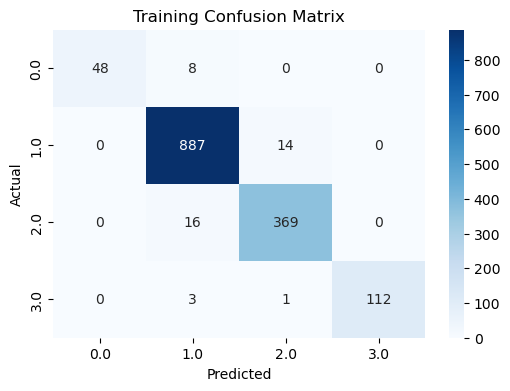

ROC-AUC (OVR): 0.9987

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92        56
         1.0       0.97      0.98      0.98       901
         2.0       0.96      0.96      0.96       385
         3.0       1.00      0.97      0.98       116

    accuracy                           0.97      1458
   macro avg       0.98      0.94      0.96      1458
weighted avg       0.97      0.97      0.97      1458


Test Set Evaluation:
Accuracy: 0.4851
Confusion Matrix (raw):
[[  0  17   7   0]
 [  0 132  80  20]
 [  0  20  31   0]
 [  0  29   0   0]]


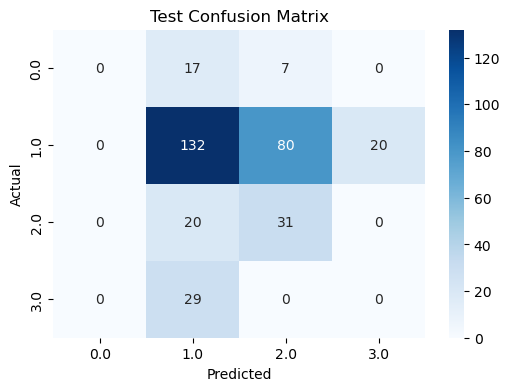

ROC-AUC (OVR): 0.5559

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        24
         1.0       0.67      0.57      0.61       232
         2.0       0.26      0.61      0.37        51
         3.0       0.00      0.00      0.00        29

    accuracy                           0.49       336
   macro avg       0.23      0.29      0.25       336
weighted avg       0.50      0.49      0.48       336




In [74]:
main()

In [65]:
# import numpy as np
# import lightgbm as lgb

# def focal_loss_lgb(preds, dtrain, alpha=0.25, gamma=2.0):
#     """
#     Focal Loss for multi-class classification for LightGBM.
    
#     Parameters:
#       preds : raw predictions (logits), shape = (n_samples * n_classes, )
#       dtrain: LightGBM dataset, contains true labels
#       alpha : balancing factor (float)
#       gamma : focusing parameter (float)
    
#     Returns:
#       grad: gradient, as 1D array
#       hess: hessian, as 1D array
#     """
#     # Get true labels and number of classes
#     labels = dtrain.get_label().astype(int)
#     n_samples = labels.shape[0]
#     n_class = preds.shape[0] // n_samples

#     # Reshape preds to (n_samples, n_class)
#     preds = preds.reshape(n_samples, n_class)
    
#     # Compute softmax probabilities in a numerically stable way
#     max_preds = np.max(preds, axis=1, keepdims=True)
#     exp_preds = np.exp(preds - max_preds)
#     sum_exp = np.sum(exp_preds, axis=1, keepdims=True)
#     prob = exp_preds / sum_exp  # shape: (n_samples, n_class)
    
#     # One-hot encode labels
#     y = np.zeros_like(prob)
#     y[np.arange(n_samples), labels] = 1

#     # Initialize gradient and hessian arrays
#     grad = np.zeros_like(prob)
#     hess = np.zeros_like(prob)
    
#     # Compute gradient and hessian for each class
#     for k in range(n_class):
#         p = prob[:, k]
#         y_k = y[:, k]
#         # The gradient for focal loss:
#         grad[:, k] = alpha * ((1 - p) ** gamma) * (p - y_k)
#         # An approximation for the Hessian (second derivative)
#         hess[:, k] = alpha * ((1 - p) ** gamma) * p * (1 - p) * (gamma * (1 - p) + 1)
    
#     # Flatten gradients and hessians as expected by LightGBM
#     return grad.reshape(-1), hess.reshape(-1)

# def focal_loss_lgb_metric(preds, dtrain, alpha=0.25, gamma=2.0):
#     """
#     Custom evaluation metric for focal loss.
    
#     Returns:
#       A tuple (name, value, is_higher_better)
#     """
#     labels = dtrain.get_label().astype(int)
#     n_samples = labels.shape[0]
#     n_class = preds.shape[0] // n_samples

#     preds = preds.reshape(n_samples, n_class)
#     max_preds = np.max(preds, axis=1, keepdims=True)
#     exp_preds = np.exp(preds - max_preds)
#     sum_exp = np.sum(exp_preds, axis=1, keepdims=True)
#     prob = exp_preds / sum_exp
    
#     # For each sample, select the probability of the true class
#     p_t = prob[np.arange(n_samples), labels]
#     # Compute focal loss per sample
#     loss = -alpha * ((1 - p_t) ** gamma) * np.log(p_t + 1e-12)
    
#     return 'focal_loss', np.mean(loss), False

# # Example training code using LightGBM with custom focal loss
# params = {
#     'objective': 'multiclass',   # We use multiclass since we have more than two classes
#     'num_class': 4,              # Change this based on your dataset
#     'learning_rate': 0.05,
#     'num_leaves': 5,             # Low complexity: few leaves
#     'max_depth': 2,              # Very shallow trees
#     'min_child_samples': 100,    # Require many samples per leaf
#     'feature_fraction': 0.7,
#     'bagging_fraction': 0.7,
#     'bagging_freq': 1,
#     'verbose': -1
# }

# # Assuming you have your training and validation data as NumPy arrays:
# # X_train, y_train, X_valid, y_valid
# dtrain = lgb.Dataset(X_train, label=y_train)
# dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)

# # Train the model using lgb.train with custom objective and evaluation metric
# model = lgb.train(
#     params,
#     dtrain,
#     valid_sets=[dvalid],
#     fobj=lambda preds, dtrain: focal_loss_lgb(preds, dtrain, alpha=0.25, gamma=2.0),
#     feval=lambda preds, dtrain: focal_loss_lgb_metric(preds, dtrain, alpha=0.25, gamma=2.0),
#     num_boost_round=1000,
#     early_stopping_rounds=50
# )

# # Now you can use model.predict on new data. For example:
# y_pred = np.argmax(model.predict(X_valid), axis=1)
